In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

T = 200
betas = linear_beta_schedule(T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0).to(device)

In [28]:
def forward_diffusion_sample(x_0, t, noise=None):
    """
    Add noise to the image x_0 at timestep t
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise, noise

In [29]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
        )

    def forward(self, x, t):
        return self.net(x)

In [30]:
def get_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x * 2 - 1
    ])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    return dataloader

def train(model, dataloader, optimizer, epochs=5):
    for epoch in range(epochs):
        for step, (x, _) in enumerate(dataloader):
            x = x.to(device)
            t = torch.randint(0, T, (x.shape[0],), device=device).long()
            x_noisy, noise = forward_diffusion_sample(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

In [31]:
@torch.no_grad()
def sample(model, image_size, num_samples):
    model.eval()
    x = torch.randn((num_samples, 1, image_size, image_size), device=device)
    for t in reversed(range(T)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_tensor)
        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]
        beta = betas[t]
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0
        x = (1 / torch.sqrt(alpha)) * (
            x - (beta / torch.sqrt(1 - alpha_bar)) * pred_noise
        ) + torch.sqrt(beta) * noise
    return x

Epoch 0: Loss 0.1439
Epoch 1: Loss 0.1160
Epoch 2: Loss 0.1280
Epoch 3: Loss 0.1088
Epoch 4: Loss 0.1211


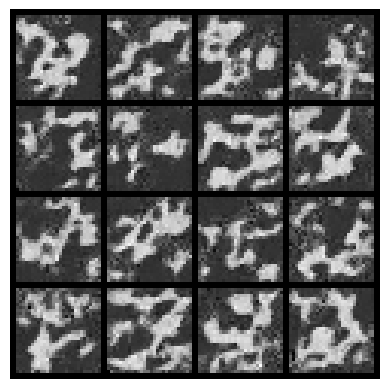

In [32]:
model = SimpleModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = get_data()

train(model, dataloader, optimizer)

samples = sample(model, 28, 16)
grid = torchvision.utils.make_grid(samples.cpu(), nrow=4, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

Streaming output truncated to the last 5000 lines.
Step 4, Loss: 0.09031760692596436
Step 4, Loss: 0.09030668437480927
Step 4, Loss: 0.09073483198881149
Step 4, Loss: 0.08292216807603836
Step 4, Loss: 0.09110189974308014
Step 4, Loss: 0.08917016535997391
Step 4, Loss: 0.08418470621109009
Step 4, Loss: 0.08965838700532913
Step 4, Loss: 0.08903058618307114
Step 4, Loss: 0.09068765491247177
Step 4, Loss: 0.0889003798365593
Step 4, Loss: 0.08968407660722733
Step 4, Loss: 0.09036370366811752
Step 4, Loss: 0.09019938111305237
Step 4, Loss: 0.09088405221700668
Step 4, Loss: 0.09076252579689026
Step 4, Loss: 0.0888107419013977
Step 4, Loss: 0.09220657497644424
Step 4, Loss: 0.0886949747800827
Step 4, Loss: 0.09014128893613815
Step 4, Loss: 0.09217758476734161
Step 4, Loss: 0.08757009357213974
Step 4, Loss: 0.08768899738788605
Step 4, Loss: 0.08945809304714203
Step 4, Loss: 0.08894099295139313
Step 4, Loss: 0.08914663642644882
Step 4, Loss: 0.08396613597869873
Step 4, Loss: 0.08861780911684036


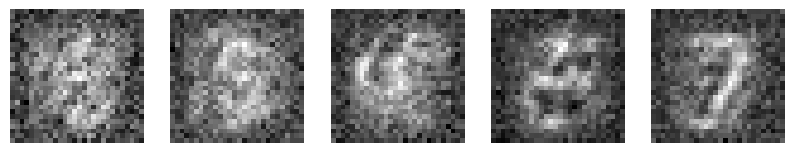

In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the Neural Network used in the reverse process
class DenoisingNN(nn.Module):
    def __init__(self):
        super(DenoisingNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 128),  # Reduced size
            nn.ReLU(),
            nn.Linear(128, 28*28)   # Output size is flattened image size
        )

    def forward(self, x):
        return self.fc(x)

# Forward process: adding noise to the data
def forward_process(x0, t, alpha_t):
    noise = torch.randn_like(x0)
    alpha_t = torch.tensor(alpha_t)  # Ensure alpha_t is a tensor
    xt = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return xt, noise

# Reverse process: denoising the data
def reverse_process(xt, model, t, alpha_t):
    xt_reconstructed = model(xt)
    return xt_reconstructed

# Training the diffusion model
def train(model, optimizer, dataloader, num_steps=10):
    model.train()
    for step in range(num_steps):
        total_loss = 0
        for x0, _ in dataloader:
            x0 = x0.view(x0.size(0), -1)  # Flatten the images
            t = torch.tensor([0.1])   # Noise level
            alpha_t = 0.5             # Example alpha_t value

            xt, epsilon = forward_process(x0, t, alpha_t)
            optimizer.zero_grad()
            xt_reconstructed = reverse_process(xt, model, t, alpha_t)
            loss = torch.mean((xt_reconstructed - x0.view(xt_reconstructed.size())) ** 2)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f"Step {step}, Loss: {loss.item()}")

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {step}, Average Loss: {avg_loss}")

# Load the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize and train the model
model = DenoisingNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training started...")
train(model, optimizer, dataloader, num_steps=10)
print("Training completed.")

# Generate images using the trained model
def generate_images(model, num_images=5):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 28*28)  # Random noise
        t = torch.tensor([0.1])   # Noise level
        alpha_t = 0.5             # Example alpha_t value
        generated_images = reverse_process(noise, model, t, alpha_t)

        plt.figure(figsize=(10, 5))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(generated_images[i].view(28, 28).numpy(), cmap='gray')
            plt.axis('off')
        plt.show()

generate_images(model)